# Simple DCGAN example:

### Install all needed libs:  
*pip install -r requirements.txt*

In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import Adam
import tensorflow as tf

import numpy as np

from PIL import Image
import imageio
import re

import sys
import os

import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage
from matplotlib.pyplot import rcParams
from IPython.display import clear_output
%matplotlib inline
#rcParams['figure.figsize'] = 4, 3
#rcParams['figure.dpi'] = 150

#### References:
https://arxiv.org/pdf/1511.06434.pdf  
https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py  
https://github.com/Newmu/dcgan_code  
https://github.com/soumith/ganhacks

#### GAN structure:

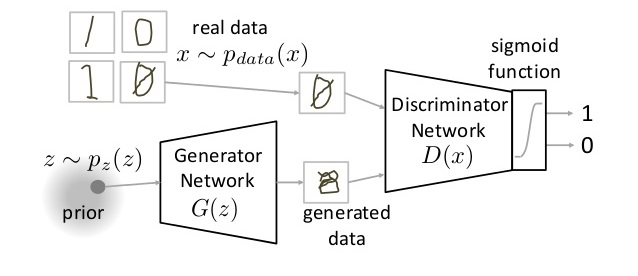

In [225]:
IPyImage(filename = "/home/gas/Pictures/g1.jpg", width=1000, height=1000)

#### Generator "deconvolution" process:

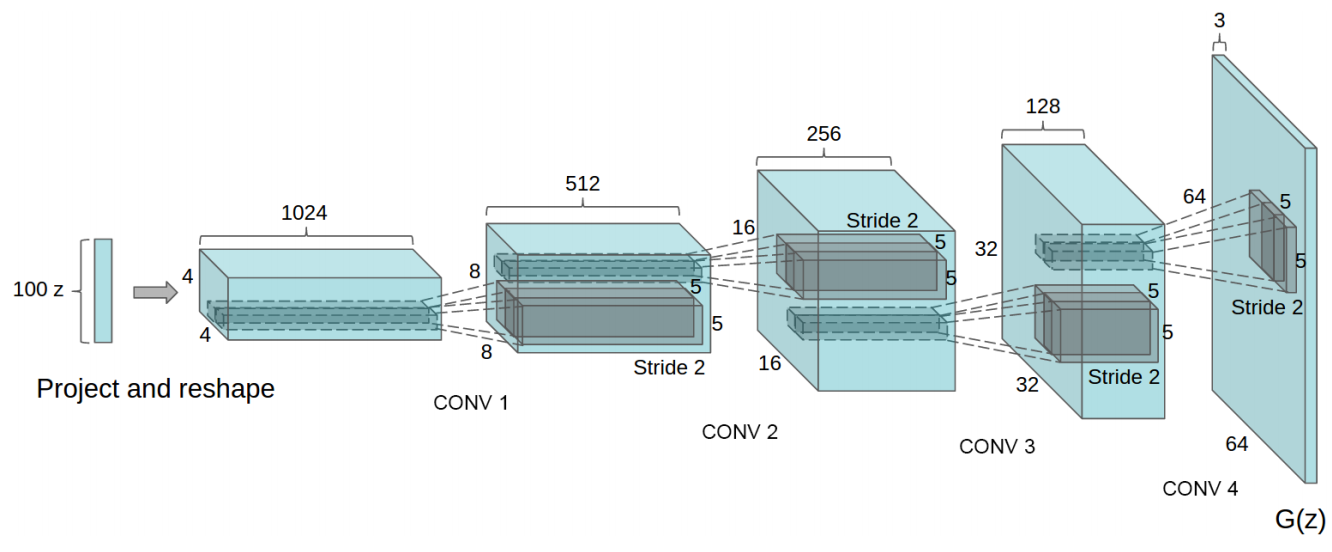

In [20]:
IPyImage(filename = "/home/gas/Pictures/DCGAN.png", width=1000, height=1000)

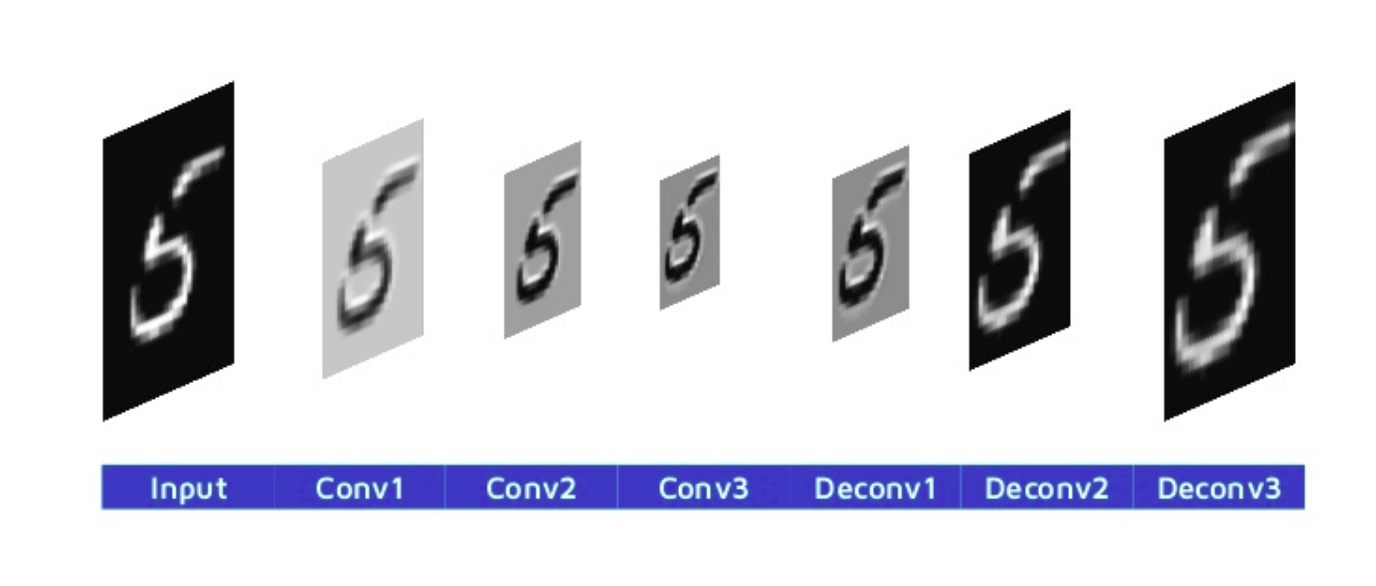

In [16]:
IPyImage(filename = "/home/gas/Pictures/Screenshot from 2018-03-02 16-50-15.png", width=1000, height=1000)

#### Relu and Leaky ReLu:

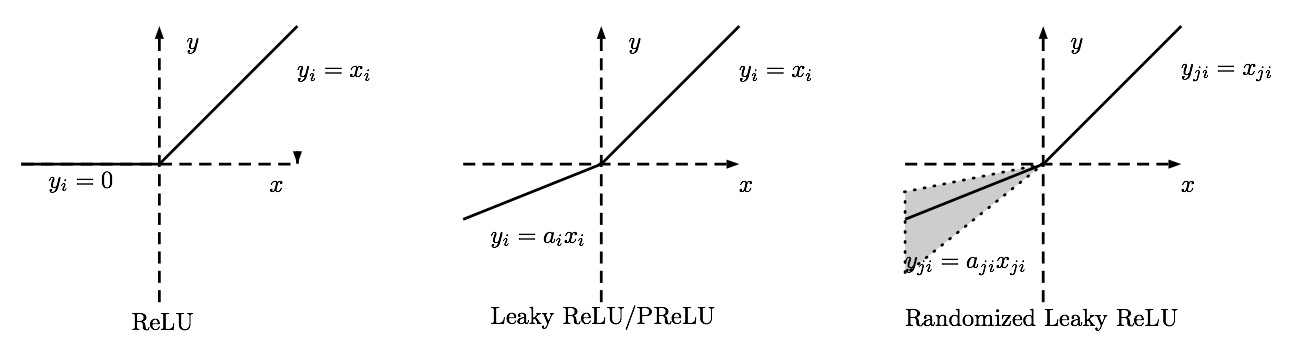

In [226]:
IPyImage(filename = "/home/gas/Pictures/1BX7l.png", width=1000, height=1000)

#### Parameters of Adam optimizer:

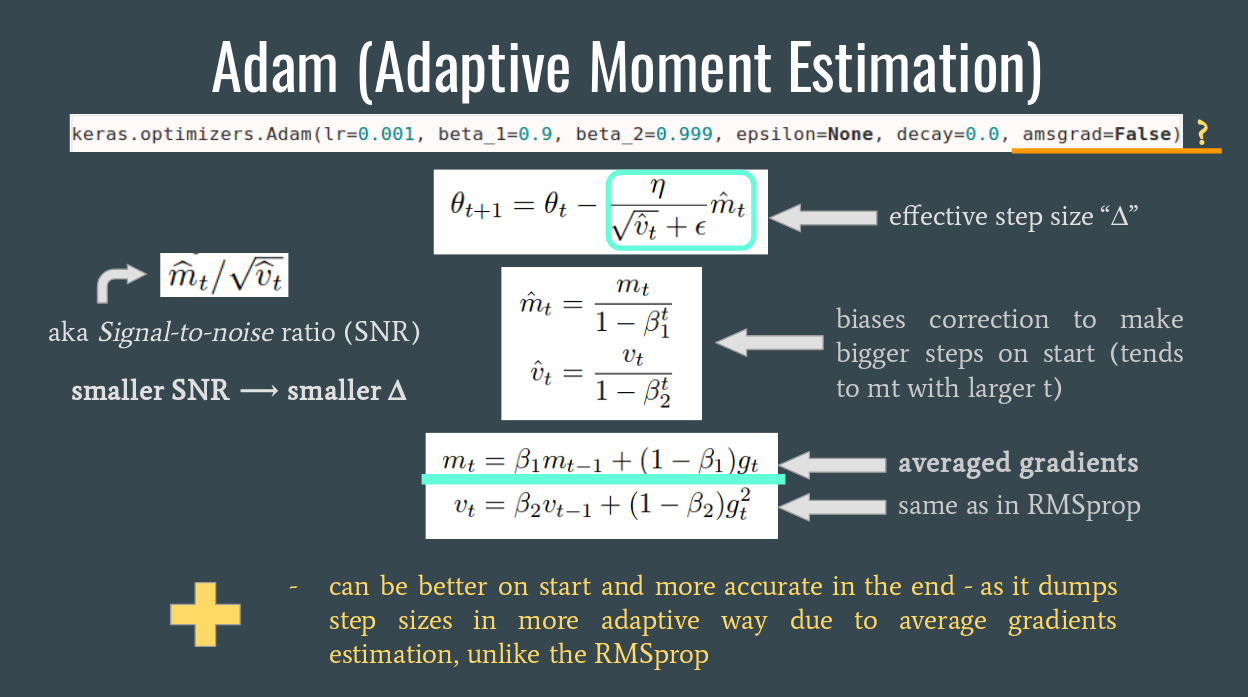

In [269]:
IPyImage(filename = "/home/gas/Pictures/Screenshot from 2018-03-09 18-53-05.png", width=1000, height=1000)

### Train DCGAN on mnist:

In [299]:
#https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

class DCGAN:
    def __init__(self, out_path, image_size=(28,28,1)):
        
        self.image_size = image_size
        self.out_path = out_path
        
        self.dLosses = []
        self.gLosses = []
        self.dAcc = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same", name='conv_2'))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8)) 
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same", name='conv_1'))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=3, padding="same", name='conv_out'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        
        model = Sequential()

        #img_shape = (self.image_size[-1], self.image_size[0], self.image_size[1])
        print(self.image_size)
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.image_size)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, X_train=None, batch_size=128, save_interval=50):

        half_batch = int(batch_size / 2)
        
        if self.images_path:
            X_train = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) 
            for f in filenames if re.search('png|jpeg|jpg', f)]
            X_train = np.array(X_train)
            #shuffle images names to read randomly
            np.random.shuffle(X_train)

        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, len(X_train), half_batch)
            if self.images_path:
                imgs = self.open_pic(X_train[idx])
            else:
                imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            self.dLosses.append(d_loss[0])
            self.gLosses.append(g_loss)
            self.dAcc.append(d_loss[1])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if (epoch % save_interval) == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        #fig.suptitle("DCGAN: Generated digits", fontsize=12)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.image_size[-1]:
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                else:
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(self.out_path + "/pic_%d.png" % epoch)
        plt.close()

Load and rescale data (we need only train set):

In [580]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# additional dimension for channel - (28,28,1)
X_train = np.expand_dims(X_train, axis=3)

Create folders to store model and results:

In [3]:
path = '/home/gas/Documents/DCGAN_workshop/data'
out_path = path+'/generated_mnist'

for p in [out_path, path]:
    if not os.path.isdir(p):
        os.makedirs(p)

Train!

In [ ]:
dcgan = DCGAN(out_path=out_path)
dcgan.train(epochs=300, X_train=X_train, batch_size=64, save_interval=50)
model = dcgan.generator

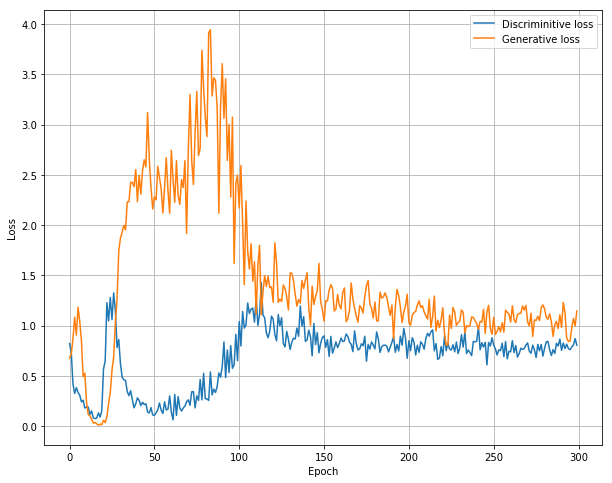

In [51]:
plt.figure(figsize=(10, 8))
plt.plot(dcgan.dLosses, label='Discriminitive loss')
plt.plot(dcgan.gLosses, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

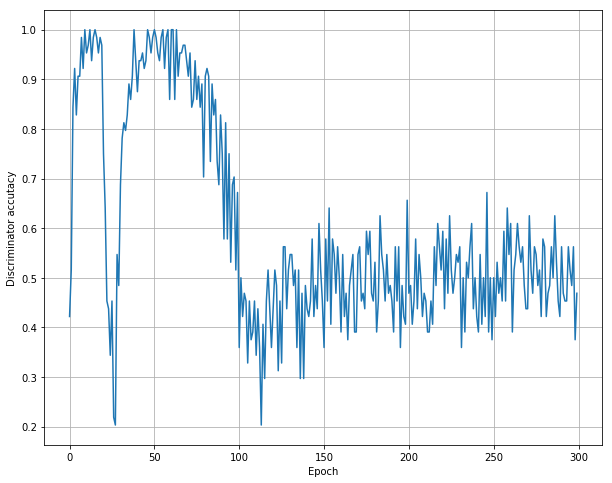

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(dcgan.dAcc)
plt.xlabel('Epoch')
plt.ylabel('Discriminator accutacy')
plt.grid(True)
plt.show()

Generator evalution over training (25 snapshots each 50th epoch):

In [7]:
generator_eval = []
names = [os.path.join(dp, f) for dp, dn, filenames in os.walk(out_path) 
             for f in filenames if re.search('png|jpeg|jpg', f)]
names.sort(key=lambda x: os.stat(os.path.join(out_path, x)).st_mtime)

for name in names:
    generator_eval.append(np.asarray(Image.open(name)))
    
gif_name = path+'/mnist_generator_evalution.gif'
imageio.mimsave(gif_name, generator_eval, duration=0.5)
#change format to show gif inside jupyter
os.rename(gif_name, gif_name+'.png')

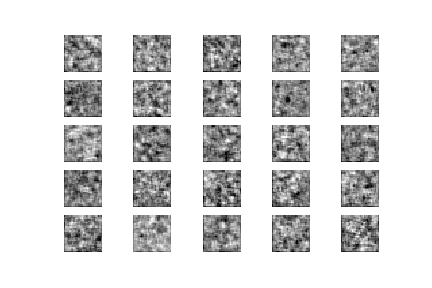

In [8]:
IPyImage(filename=gif_name + '.png', width=500, height=500)

Save fitted generator:

In [574]:
model_json = model.to_json()
with open(path+"/mnist_GAN.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(path+"/mnist_GAN.h5")

Load saved model:

In [575]:
with open(path+"/mnist_GAN.json", "r") as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
model.load_weights(path+"/mnist_GAN.h5")

### Play with latent vector:

Get random state before to "freeze" it later:

In [512]:
state = np.random.get_state()

Generate picture:

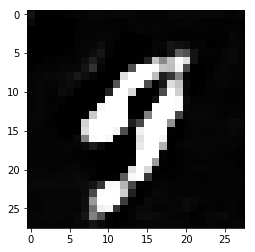

In [576]:
np.random.set_state(state)
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = model.predict(noise)
plt.imshow(gen_imgs[0, :,:,0], cmap='gray')
plt.show()

Change one of the variables of noise vector and see what happens :)  
**Remember**: noise vector generated with 0 mean and $\sigma$=1

In [566]:
ind = 80
Min, Max = -2, 2
num_steps = 100

gen_imgs = []
for val in np.linspace(Min, Max, num_steps):
    noise[0, ind] = val
    gen_img = model.predict(noise)
    #rescale picture back
    gen_img = gen_img*127.5+127.5
    gen_imgs.append(gen_img[0, :, :, 0].astype(np.uint8))

Make a gif animation:

In [567]:
gif_name = path+'/mnist_0_param_change.gif'
imageio.mimsave(gif_name, gen_imgs, duration=0.02)
#change format to show gif inside jupyter
os.rename(gif_name, gif_name+'.png')

In [568]:
IPyImage(filename=gif_name + '.png', width=250, height=250)